In [1]:
# -*- coding:utf8 -*-
import re
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
% matplotlib inline
import seaborn as sns
sns.set_style('whitegrid')

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split

os.chdir('/Users/hahadsg/MyProjects/MyKaggle/Titanic')

In [2]:
train_df = pd.read_csv('./data/train.csv')
test_df = pd.read_csv('./data/test.csv')

train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
train_df.info()
print('----------------------------------------')
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB
----------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            332 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-null

In [4]:
# 删除没用的字段
train_df = train_df.drop(['PassengerId', 'Ticket', 'Cabin'], axis=1)
test_df = test_df.drop(['Ticket', 'Cabin'], axis=1)

In [5]:
# Name
# 获取Title
title_pattern = re.compile(r'(.*, )|(\..*)')
train_df['Title'] = train_df['Name'].apply(lambda x: title_pattern.sub('', x))
test_df['Title'] = test_df['Name'].apply(lambda x: title_pattern.sub('', x))

# 显示Title-Sex分布
print('处理前Title-Sex分布\n')
print(train_df.pivot_table(index='Sex', columns='Title', values='Name', aggfunc=len).fillna(0))
print('----------------------------------------')

# 将Title分类
rare_title_list = ['Dona', 'Lady', 'the Countess','Capt', 'Col', 'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer']
train_df.loc[train_df['Title'].isin(rare_title_list), 'Title'] = 'Rare Title'
train_df.loc[train_df['Title'] == 'Mlle', 'Title'] = 'Miss'
train_df.loc[train_df['Title'] == 'Ms', 'Title'] = 'Miss'
train_df.loc[train_df['Title'] == 'Mme', 'Title'] = 'Mrs'
test_df.loc[test_df['Title'].isin(rare_title_list), 'Title'] = 'Rare Title'
test_df.loc[test_df['Title'] == 'Mlle', 'Title'] = 'Miss'
test_df.loc[test_df['Title'] == 'Ms', 'Title'] = 'Miss'
test_df.loc[test_df['Title'] == 'Mme', 'Title'] = 'Mrs'

# 显示Title-Sex分布
print('处理后Title-Sex分布\n')
print(train_df.pivot_table(index='Sex', columns='Title', values='Name', aggfunc=len).fillna(0))
print('----------------------------------------')

# 生成哑变量
train_df = train_df.join( pd.get_dummies(train_df['Title']).drop(['Rare Title'], axis=1) )
test_df = test_df.join( pd.get_dummies(test_df['Title']).drop(['Rare Title'], axis=1) )
train_df.drop(['Title', 'Name'], axis=1, inplace=True)
test_df.drop(['Title', 'Name'], axis=1, inplace=True)
print(train_df.head())
print('----------------------------------------')
print(test_df.head())

处理前Title-Sex分布

Title   Capt  Col  Don   Dr  Jonkheer  Lady  Major  Master   Miss  Mlle  Mme  \
Sex                                                                            
female   0.0  0.0  0.0  1.0       0.0   1.0    0.0     0.0  182.0   2.0  1.0   
male     1.0  2.0  1.0  6.0       1.0   0.0    2.0    40.0    0.0   0.0  0.0   

Title      Mr    Mrs   Ms  Rev  Sir  the Countess  
Sex                                                
female    0.0  125.0  1.0  0.0  0.0           1.0  
male    517.0    0.0  0.0  6.0  1.0           0.0  
----------------------------------------
处理后Title-Sex分布

Title   Master   Miss     Mr    Mrs  Rare Title
Sex                                            
female     0.0  185.0    0.0  126.0         3.0
male      40.0    0.0  517.0    0.0        20.0
----------------------------------------
   Survived  Pclass     Sex   Age  SibSp  Parch     Fare Embarked  Master  \
0         0       3    male  22.0      1      0   7.2500        S       0   
1         1

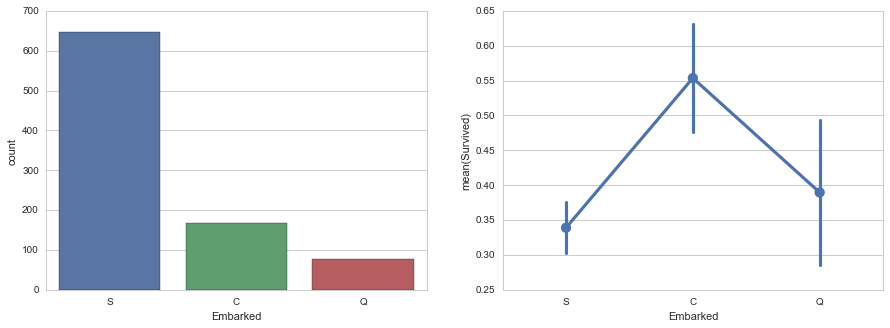

In [6]:
# Embarked
# 处理：由于就train_df有两个缺失值 就把缺失值填补为S(最多)
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(15,5))
train_df['Embarked'].fillna( train_df['Embarked'].dropna().mode()[0], inplace=True )

# 分布
sns.countplot(x='Embarked', data=train_df, ax=ax1)
# 集中情况
sns.pointplot(x='Embarked', y='Survived', data=train_df, ax=ax2)

# 设置哑变量
train_df = train_df.join( pd.get_dummies(train_df['Embarked']).drop(['S'], axis=1) )
test_df = test_df.join( pd.get_dummies(test_df['Embarked']).drop(['S'], axis=1) )
train_df.drop(['Embarked'], axis=1, inplace=True)
test_df.drop(['Embarked'], axis=1, inplace=True)


In [7]:
train_df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Master,Miss,Mr,Mrs,C,Q
0,0,3,male,22.0,1,0,7.2500,0,0,1,0,0,0
1,1,1,female,38.0,1,0,71.2833,0,0,0,1,1,0
2,1,3,female,26.0,0,0,7.9250,0,1,0,0,0,0
3,1,1,female,35.0,1,0,53.1000,0,0,0,1,0,0
4,0,3,male,35.0,0,0,8.0500,0,0,1,0,0,0


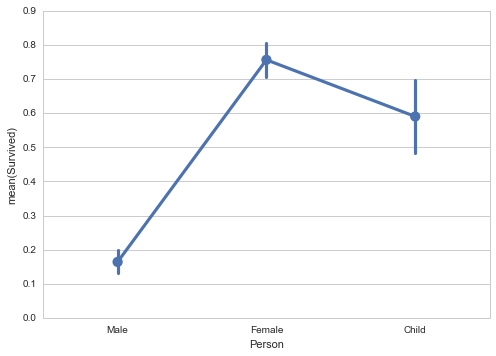

In [8]:
# Sex
# 处理：分为Male, Female, Child（Age<16的为Child）
def get_person(passenger):
    age, sex = passenger
    return 'Child' if age < 16 else sex.capitalize()

train_df['Person'] = train_df[['Age', 'Sex']].apply(get_person, axis=1)
test_df['Person'] = test_df[['Age', 'Sex']].apply(get_person, axis=1)

# Sex字段没有用了 去掉
train_df.drop(['Sex'], axis=1, inplace=True)
test_df.drop(['Sex'], axis=1, inplace=True)

# 查看数据
sns.pointplot(x='Person', y='Survived', data=train_df)

# 设置哑变量
train_df = train_df.join( pd.get_dummies(train_df['Person']).drop(['Male'], axis=1) )
test_df = test_df.join( pd.get_dummies(test_df['Person']).drop(['Male'], axis=1) )
train_df.drop(['Person'], axis=1, inplace=True)
test_df.drop(['Person'], axis=1, inplace=True)

In [9]:
train_df.head()

,Survived,Pclass,Age,SibSp,Parch,Fare,Master,Miss,Mr,Mrs,C,Q,Child,Female
0,0,3,22.0,1,0,7.2500,0,0,1,0,0,0,0,0
1,1,1,38.0,1,0,71.2833,0,0,0,1,1,0,0,1
2,1,3,26.0,0,0,7.9250,0,1,0,0,0,0,0,1
3,1,1,35.0,1,0,53.1000,0,0,0,1,0,0,0,1
4,0,3,35.0,0,0,8.0500,0,0,1,0,0,0,0,0


/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/ipykernel/__main__.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/ipykernel/__main__.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


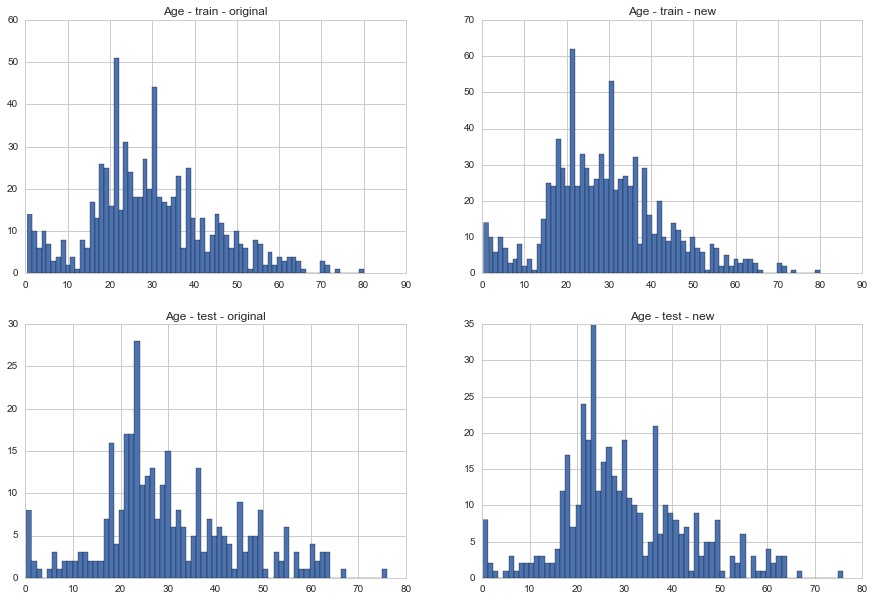

In [10]:
# Age
# 处理：填补(mean-std) between (mean+std)
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2,figsize=(15,10))
ax1.set_title('Age - train - original')
ax2.set_title('Age - train - new')
ax3.set_title('Age - test - original')
ax4.set_title('Age - test - new')

# 处理前
train_df['Age'].hist(bins=70, ax=ax1)
test_df['Age'].hist(bins=70, ax=ax3)

# 获取均值 标准差 空值数量
train_age_mean = train_df['Age'].mean()
train_age_std = train_df['Age'].std()
train_age_nan_cnt = train_df['Age'].isnull().sum()

test_age_mean = test_df['Age'].mean()
test_age_std = test_df['Age'].std()
test_age_nan_cnt = test_df['Age'].isnull().sum()

# 生成随机值
train_rand = np.random.randint(train_age_mean - train_age_std, train_age_mean + train_age_std, size=train_age_nan_cnt)
test_rand = np.random.randint(test_age_mean - test_age_std, test_age_mean + test_age_std, size=test_age_nan_cnt)

# 填补
train_df['Age'][train_df['Age'].isnull()] = train_rand
test_df['Age'][test_df['Age'].isnull()] = test_rand

# 处理后
train_df['Age'].hist(bins=70, ax=ax2)
test_df['Age'].hist(bins=70, ax=ax4)

train dataset null value num: 0
test dataset null value num: 1


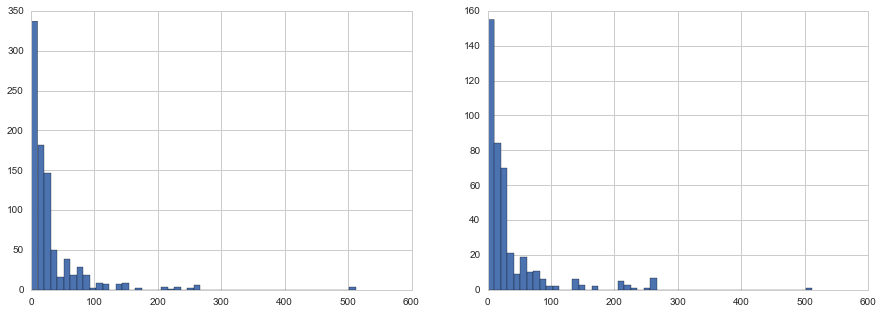

In [11]:
# Fare
# 处理：由于缺失值很少，直接填充均值
print('train dataset null value num:', train_df['Fare'].isnull().sum()) # output: 0
print('test dataset null value num:', test_df['Fare'].isnull().sum()) # output: 1

# 填充均值
train_df['Fare'].fillna( train_df['Fare'].mean(), inplace=True )
test_df['Fare'].fillna( test_df['Fare'].mean(), inplace=True )

fig, (ax1, ax2) = plt.subplots(1,2,figsize=(15,5))
train_df['Fare'].hist(bins=50, ax=ax1)
test_df['Fare'].hist(bins=50, ax=ax2)

In [12]:
# 训练数据
X_train = train_df.drop(['Survived'], axis=1)
y_train = train_df['Survived']

# X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2, random_state=1)
X_test = test_df.drop(['PassengerId'], axis=1)

In [13]:
# random forest
random_forest = RandomForestClassifier(n_estimators=100, max_depth=10)
random_forest.fit(X_train, y_train)
y_pred = random_forest.predict(X_test)
print(random_forest.score(X_train, y_train))
# print(random_forest.score(X_test, y_test))

0.94051627385


In [14]:
feature_importances_df = pd.DataFrame(data=[random_forest.feature_importances_], columns=X_train.columns)
feature_importances_df.sort_values(by=0, axis=1, ascending=False)

,Fare,Age,Mr,Female,Pclass,SibSp,Miss,Mrs,Parch,Child,C,Q,Master
0,0.201967,0.164391,0.154645,0.137814,0.094726,0.06245,0.04843,0.039756,0.035208,0.021263,0.016889,0.012818,0.009645


In [15]:
# Logistic Regression
# logistic_regression = LogisticRegression()
# logistic_regression.fit(X_train, y_train)
# # y_pred = logistic_regression.predict(X_test)
# print(logistic_regression.score(X_train, y_train))
# print(logistic_regression.score(X_test, y_test))

In [16]:
# SVM
# svc = SVC()
# svc.fit(X_train, y_train)
# # y_pred = svc.predict(X_test)
# print(svc.score(X_train, y_train))
# print(svc.score(X_test, y_test))

In [17]:
result = pd.DataFrame({
        'PassengerId': test_df['PassengerId'],
        'Survived': y_pred,
    }
)
result.to_csv('./data/result.csv', index=False)

In [18]:
train_df.info()
print('----------------------------------------')
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 14 columns):
Survived    891 non-null int64
Pclass      891 non-null int64
Age         891 non-null float64
SibSp       891 non-null int64
Parch       891 non-null int64
Fare        891 non-null float64
Master      891 non-null uint8
Miss        891 non-null uint8
Mr          891 non-null uint8
Mrs         891 non-null uint8
C           891 non-null uint8
Q           891 non-null uint8
Child       891 non-null uint8
Female      891 non-null uint8
dtypes: float64(2), int64(4), uint8(8)
memory usage: 48.8 KB
----------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 14 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Age            418 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Fare           418 non-null float64
Master         418 non-null uint8
Miss    